In [48]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from contrastive.backbones.pointnet import PointNetCls
from torch.nn.utils.rnn import pack_padded_sequence

In [29]:
data = np.load("/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/2mm/CINGULATE/mask/Rskeleton.npy")
data.shape

(1114, 17, 40, 38, 1)

In [30]:
np.product(data.shape)

28785760

In [31]:
points = np.nonzero(data)
for coord in points:
    print(len(coord))

points

870630
870630
870630
870630
870630


(array([   0,    0,    0, ..., 1113, 1113, 1113]),
 array([ 1,  1,  1, ..., 13, 13, 13]),
 array([ 7,  8,  9, ..., 11, 12, 12]),
 array([23, 23, 22, ..., 33, 29, 30]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [62]:
clouds = []

for i in range(data.shape[0]):
    point_cloud = np.array(data[i].nonzero()[:3])
    clouds.append(point_cloud)

clouds[0].shape, clouds[1].shape

((3, 912), (3, 711))

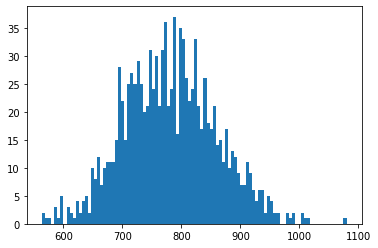

In [63]:
lengths = []

for point_cloud in clouds:
    #print(len(point_cloud), len(point_cloud[0]))
    lengths.append(point_cloud.shape[1])

plt.hist(lengths, bins=100)
plt.show()

In [64]:
dats = data[0]

point_cloud = np.nonzero(dats)

point_cloud = np.matrix(point_cloud[:3])
print(point_cloud.shape)
#point_cloud = np.expand_dims(point_cloud, axis=0)
#print(point_cloud.shape)

(3, 912)


In [36]:
points = [point_cloud for i in range(10)]
points = np.array(points)

semi_points = [point_cloud[:,:500] for i in range(10)]
semi_points = np.array(semi_points)

points.shape, semi_points.shape

((10, 3, 912), (10, 3, 500))

In [37]:
X = torch.from_numpy(points).type(torch.FloatTensor)
semi_X = torch.from_numpy(semi_points).type(torch.FloatTensor)
X, semi_X

(tensor([[[ 1.,  1.,  1.,  ..., 12., 12., 12.],
          [ 7.,  8.,  9.,  ..., 14., 18., 31.],
          [23., 23., 22.,  ..., 14., 16., 11.]],
 
         [[ 1.,  1.,  1.,  ..., 12., 12., 12.],
          [ 7.,  8.,  9.,  ..., 14., 18., 31.],
          [23., 23., 22.,  ..., 14., 16., 11.]],
 
         [[ 1.,  1.,  1.,  ..., 12., 12., 12.],
          [ 7.,  8.,  9.,  ..., 14., 18., 31.],
          [23., 23., 22.,  ..., 14., 16., 11.]],
 
         ...,
 
         [[ 1.,  1.,  1.,  ..., 12., 12., 12.],
          [ 7.,  8.,  9.,  ..., 14., 18., 31.],
          [23., 23., 22.,  ..., 14., 16., 11.]],
 
         [[ 1.,  1.,  1.,  ..., 12., 12., 12.],
          [ 7.,  8.,  9.,  ..., 14., 18., 31.],
          [23., 23., 22.,  ..., 14., 16., 11.]],
 
         [[ 1.,  1.,  1.,  ..., 12., 12., 12.],
          [ 7.,  8.,  9.,  ..., 14., 18., 31.],
          [23., 23., 22.,  ..., 14., 16., 11.]]]),
 tensor([[[ 1.,  1.,  1.,  ...,  9.,  9.,  9.],
          [ 7.,  8.,  9.,  ..., 21., 21., 21.],
      

In [38]:
net = PointNetCls(k=4)
net.eval()

Y, trans, trans_feat = net.forward(X)

print(X.shape, Y.shape)
Y

torch.Size([10, 3, 912]) torch.Size([10, 4])


tensor([[-1.2886, -1.3629, -1.3529, -1.5610],
        [-1.2886, -1.3629, -1.3529, -1.5610],
        [-1.2886, -1.3629, -1.3529, -1.5610],
        [-1.2886, -1.3629, -1.3529, -1.5610],
        [-1.2886, -1.3629, -1.3529, -1.5610],
        [-1.2886, -1.3629, -1.3529, -1.5610],
        [-1.2886, -1.3629, -1.3529, -1.5610],
        [-1.2886, -1.3629, -1.3529, -1.5610],
        [-1.2886, -1.3629, -1.3529, -1.5610],
        [-1.2886, -1.3629, -1.3529, -1.5610]], grad_fn=<LogSoftmaxBackward0>)

In [39]:
#net = PointNetCls(k=4)
#net.eval()

semi_Y, trans, trans_feat = net.forward(semi_X)

print(semi_X.shape, semi_Y.shape)
semi_Y

torch.Size([10, 3, 500]) torch.Size([10, 4])


tensor([[-1.2973, -1.3581, -1.3525, -1.5559],
        [-1.2973, -1.3581, -1.3525, -1.5559],
        [-1.2973, -1.3581, -1.3525, -1.5559],
        [-1.2973, -1.3581, -1.3525, -1.5559],
        [-1.2973, -1.3581, -1.3525, -1.5559],
        [-1.2973, -1.3581, -1.3525, -1.5559],
        [-1.2973, -1.3581, -1.3525, -1.5559],
        [-1.2973, -1.3581, -1.3525, -1.5559],
        [-1.2973, -1.3581, -1.3525, -1.5559],
        [-1.2973, -1.3581, -1.3525, -1.5559]], grad_fn=<LogSoftmaxBackward0>)

## accept point clouds with different sizes

See https://github.com/charlesq34/pointnet/issues/161

In [70]:
def zero_padding(cloud, n_max, shuffle=False):
    return np.pad(cloud, ((0,0),(0,n_max-cloud.shape[1])))

zero_padding(clouds[0], 1080).shape

(3, 1080)

In [71]:
n_max = np.max([clouds[i].shape[1] for i in range(len(clouds))])
print(n_max)

padded_clouds = np.array([zero_padding(cloud, n_max) for cloud in clouds])
padded_clouds.shape

1080


(1114, 3, 1080)

In [73]:
padded_X = torch.from_numpy(padded_clouds).type(torch.FloatTensor)
padded_X.shape

torch.Size([1114, 3, 1080])

In [74]:
pack = pack_padded_sequence(padded_X, lengths, batch_first=True, enforce_sorted=False)
pack.data.shape

torch.Size([3342, 1080])

In [75]:
padded_Y, _, _ = net.forward(pack[:10])
padded_Y.shape

AttributeError: 'tuple' object has no attribute 'size'

# import bug for pointnet

In [2]:
from contrastive.backbones.pointnet import PointNetCls
from contrastive.models.contrastive_learner import ContrastiveLearner

INFO: you are probably not in a brainvisa environment. Probably OK.
